## 📌 Build Video Games Sales Prediction

## Import all the required libraries

In [1]:
# Loading libraries
import os
import joblib
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from termcolor import colored
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

## Data Collection

In [2]:
# Reading the Data
data = pd.read_csv("vgsales.csv")
data

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


In [3]:
# Checking the dimensions of the dataset (rows, columns) 📏
data.shape

(16598, 11)

## Data Cleaning and Preprocessing

## Removing name 

In [4]:
# Remove name column (unnesscary for perdiction)
data = data.drop(['Name'], axis =1)

In [5]:
# Displaying the original number of rows in the dataset 📊
print(f"✅ Original dataset size: {data.shape[0]} rows")

✅ Original dataset size: 16598 rows


📌 Function to print tabulated data

In [6]:
# Utility function to neatly print a DataFrame with a title and a styled table format ✨
def print_table(title, df):
    print(f"\n📌 {title}:\n")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=True))

## 📌 Checking Outliers

In [7]:
# Select ALL numerical columns dynamically
num_cols = data.select_dtypes(include=['number']).columns
data_numeric = data[num_cols]

# Compute Q1, Q3, and IQR
Q1 = data_numeric.quantile(0.25)  
Q3 = data_numeric.quantile(0.75)  
IQR = Q3 - Q1  

# Define outlier condition
outliers = ((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR)))

# Count total outliers per column
outlier_counts = outliers.sum()

# Display outlier counts in a beautiful, bigger table
outlier_table = pd.DataFrame({"Numerical Column": outlier_counts.index, "Total Outliers": outlier_counts.values})

# Styling the table
styled_table = (outlier_table.style
                .set_caption("🚨 Outlier Summary in Video Game Data 🚀")
                .set_properties(**{"background-color": "#FFF3CD",  # Light yellow background
                                   "color": "black",
                                   "border": "2px solid black",
                                   "font-size": "18px",  # Bigger font size
                                   "text-align": "center"})
                .set_table_styles([{"selector": "th",
                                    "props": [("font-size", "20px"),  # Bigger header font
                                              ("text-align", "center"),
                                              ("border", "2px solid black")]}]))

# Display the table
display(styled_table)




,Numerical Column,Total Outliers
0,Rank,0
1,Year,305
2,NA_Sales,1681
3,EU_Sales,2081
4,JP_Sales,2425
5,Other_Sales,1665
6,Global_Sales,1893


In [8]:
# Select ALL numerical columns dynamically
num_cols = data.select_dtypes(include=['number']).columns
data_numeric = data[num_cols]

# Compute Q1, Q3, and IQR
Q1 = data_numeric.quantile(0.25)  
Q3 = data_numeric.quantile(0.75)  
IQR = Q3 - Q1  

# Define outlier condition
outliers = ((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR)))

# Count total outliers before removal
outlier_counts_before = outliers.sum()

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data_cleaned = data[~outliers.any(axis=1)]

# Count total outliers after removal (should be zero)
outlier_counts_after = ((data_cleaned[num_cols] < lower_bound) | (data_cleaned[num_cols] > upper_bound)).sum()

# Compute total removed outliers
outliers_removed = outlier_counts_before - outlier_counts_after

# Display the results in a bigger, beautifully styled table
outlier_summary = pd.DataFrame({
    "Numerical Column": num_cols,
    "Total Outliers Before": outlier_counts_before.values,
    "Outliers Removed": outliers_removed.values,
    "Total Outliers After": outlier_counts_after.values
})

# Apply styling for a professional, larger table
styled_table = (outlier_summary.style
                .set_caption("📊 Outliers Removed from Video Game Data 🚀")
                .set_properties(**{"background-color": "#E8F6EF",  
                                   "color": "black",
                                   "border": "2px solid black",
                                   "font-size": "18px",  # Bigger font size
                                   "text-align": "center",
                                   "padding": "8px"})
                .set_table_styles([{"selector": "th",
                                    "props": [("font-size", "20px"),  # Bigger header font
                                              ("text-align", "center"),
                                              ("border", "2px solid black"),
                                              ("padding", "10px")]}]))

# Display the table
display(styled_table)



,Numerical Column,Total Outliers Before,Outliers Removed,Total Outliers After
0,Rank,0,0,0
1,Year,305,305,0
2,NA_Sales,1681,1681,0
3,EU_Sales,2081,2081,0
4,JP_Sales,2425,2425,0
5,Other_Sales,1665,1665,0
6,Global_Sales,1893,1893,0


In [9]:
# Showing the size of the cleaned dataset and how many outliers were removed 🧹
print(f"✅ Cleaned dataset size: {data_cleaned.shape[0]} rows (Outliers removed: {data.shape[0] - data_cleaned.shape[0]})")

✅ Cleaned dataset size: 11926 rows (Outliers removed: 4672)


In [10]:
# Checking and displaying the number of missing (NaN) values in each column before cleaning 🔍
nan_values = data.isna().sum().to_frame(name="NaN Values")
print_table("NaN Values Before Cleaning", nan_values)


📌 NaN Values Before Cleaning:

╒══════════════╤══════════════╕
│              │   NaN Values │
╞══════════════╪══════════════╡
│ Rank         │            0 │
├──────────────┼──────────────┤
│ Platform     │            0 │
├──────────────┼──────────────┤
│ Year         │          271 │
├──────────────┼──────────────┤
│ Genre        │            0 │
├──────────────┼──────────────┤
│ Publisher    │           58 │
├──────────────┼──────────────┤
│ NA_Sales     │            0 │
├──────────────┼──────────────┤
│ EU_Sales     │            0 │
├──────────────┼──────────────┤
│ JP_Sales     │            0 │
├──────────────┼──────────────┤
│ Other_Sales  │            0 │
├──────────────┼──────────────┤
│ Global_Sales │            0 │
╘══════════════╧══════════════╛


In [11]:
# Drop rows where 'Year' or 'Publisher' have missing values 🧹
data = data.dropna()

# Recheck and display missing values after cleaning 🔎
nan_values = data.isna().sum().to_frame(name="NaN Values")
print_table("NaN Values After Cleaning", nan_values)


📌 NaN Values After Cleaning:

╒══════════════╤══════════════╕
│              │   NaN Values │
╞══════════════╪══════════════╡
│ Rank         │            0 │
├──────────────┼──────────────┤
│ Platform     │            0 │
├──────────────┼──────────────┤
│ Year         │            0 │
├──────────────┼──────────────┤
│ Genre        │            0 │
├──────────────┼──────────────┤
│ Publisher    │            0 │
├──────────────┼──────────────┤
│ NA_Sales     │            0 │
├──────────────┼──────────────┤
│ EU_Sales     │            0 │
├──────────────┼──────────────┤
│ JP_Sales     │            0 │
├──────────────┼──────────────┤
│ Other_Sales  │            0 │
├──────────────┼──────────────┤
│ Global_Sales │            0 │
╘══════════════╧══════════════╛


✅ Now the data is completely clean

In [12]:
# Displaying the cleaned dataset size and the total number of rows removed 🧹
print(f"✅ Cleaned dataset size: {data_cleaned.shape[0]} rows (removed: {data.shape[0] - data_cleaned.shape[0]})")

✅ Cleaned dataset size: 11926 rows (removed: 4365)


In [13]:
# Displaying the final dataset size after all cleaning steps, ready for training 🚀
print(f"✅ Final dataset size to train: {data.shape[0]} rows")

✅ Final dataset size to train: 16291 rows


## Data Exploration

In [14]:
# Displaying the current state of the dataset for exploration 🔍
data

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...
16593,16596,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


In [15]:
# Checking the dataset's dimensions (rows, columns) during exploration 📏
data.shape

(16291, 10)

## 1️⃣ Dataset Overview

In [16]:
# Printing a quick overview of the dataset structure (column types, non-null counts) 🗂️
print("\n🗂️ DATASET OVERVIEW:\n")
data.info


🗂️ DATASET OVERVIEW:



<bound method DataFrame.info of         Rank Platform    Year         Genre   Publisher  NA_Sales  EU_Sales  \
0          1      Wii  2006.0        Sports    Nintendo     41.49     29.02   
1          2      NES  1985.0      Platform    Nintendo     29.08      3.58   
2          3      Wii  2008.0        Racing    Nintendo     15.85     12.88   
3          4      Wii  2009.0        Sports    Nintendo     15.75     11.01   
4          5       GB  1996.0  Role-Playing    Nintendo     11.27      8.89   
...      ...      ...     ...           ...         ...       ...       ...   
16593  16596      GBA  2002.0      Platform       Kemco      0.01      0.00   
16594  16597       GC  2003.0       Shooter  Infogrames      0.01      0.00   
16595  16598      PS2  2008.0        Racing  Activision      0.00      0.00   
16596  16599       DS  2010.0        Puzzle    7G//AMES      0.00      0.01   
16597  16600      GBA  2003.0      Platform     Wanadoo      0.01      0.00   

       JP_Sales  Ot

## 2️⃣ Checking Data Types

In [17]:
# Displaying the data type of each column for better understanding of the dataset 🧩
data_types = data.dtypes.to_frame(name="Data Type")
print_table("Column Data Types", data_types)


📌 Column Data Types:

╒══════════════╤═════════════╕
│              │ Data Type   │
╞══════════════╪═════════════╡
│ Rank         │ int64       │
├──────────────┼─────────────┤
│ Platform     │ object      │
├──────────────┼─────────────┤
│ Year         │ float64     │
├──────────────┼─────────────┤
│ Genre        │ object      │
├──────────────┼─────────────┤
│ Publisher    │ object      │
├──────────────┼─────────────┤
│ NA_Sales     │ float64     │
├──────────────┼─────────────┤
│ EU_Sales     │ float64     │
├──────────────┼─────────────┤
│ JP_Sales     │ float64     │
├──────────────┼─────────────┤
│ Other_Sales  │ float64     │
├──────────────┼─────────────┤
│ Global_Sales │ float64     │
╘══════════════╧═════════════╛


## 3️⃣ Checking for Duplicates

In [18]:
# Checking and counting duplicate rows in the dataset 🛑
duplicate_count = data.duplicated().sum()
print(f"\n🛑 Total Duplicate Rows: {duplicate_count}")

# Displaying a Boolean Series indicating duplicate rows 🔎
data.duplicated()


🛑 Total Duplicate Rows: 0


0        False
1        False
2        False
3        False
4        False
         ...  
16593    False
16594    False
16595    False
16596    False
16597    False
Length: 16291, dtype: bool

## 🎮 Analyzing Cateogry Columns in Video Game Data

In [19]:
# Identifying categorical (text/object) columns using apply() and lambda 🎭
category_columns = data.apply(lambda col: col.dtype == 'object').index[data.dtypes == 'object'].tolist()

print(f"\n🎭 Category Columns ({len(category_columns)}): {category_columns}")


🎭 Category Columns (3): ['Platform', 'Genre', 'Publisher']


## 🎮 Identifying Numerical Columns in Video Game Data

In [20]:
# Identifying numerical columns (integer and float types) 🔢
numeric_columns = [col for col in data.columns if data[col].dtype == 'int64' or data[col].dtype == 'float64']

print(f"\n🔢 Numerical Columns ({len(numeric_columns)}): {numeric_columns}")



🔢 Numerical Columns (7): ['Rank', 'Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']


## ✅ So to show the total number of columns

In [21]:
# Counting and displaying the total number of columns in the dataset 🧮
print(f"The dataset has {len(category_columns) + len(numeric_columns)} columns.")

The dataset has 10 columns.


## 🎯 Sales Data Skewness Analysis

In [22]:
# Define sales columns
sales_columns = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]

# Compute skewness and determine the state
sales_skewness = {
    col: {"Skewness": skew(data[col].dropna()), 
          "State": "Positive" if skew(data[col].dropna()) > 0 
          else "Negative" if skew(data[col].dropna()) < 0 
          else "Zero"}
    for col in sales_columns
}

# Convert to DataFrame
skewness_df = pd.DataFrame.from_dict(sales_skewness, orient="index").reset_index()
skewness_df.columns = ["Sales Category", "Skewness Value", "State"]

# Function to style the skewness table
def style_skewness(df):
    def highlight_row(row):
        skew_val = row["Skewness Value"]
        
        skew_style = "background-color: #D4EDDA; color: black; font-weight: bold; font-size:14px;"  # Normal skewness (default)
        if skew_val > 1:
            skew_style = "background-color: #FF6B6B; color: white; font-weight: bold; font-size:14px;"  # Highly positive
        elif skew_val < -1:
            skew_style = "background-color: #4A90E2; color: white; font-weight: bold; font-size:14px;"  # Highly negative
        
        state_style = "background-color: #FFE066; color: black; font-weight: bold; font-size:14px;"  # Yellow for state

        return [None, skew_style, state_style]  # Apply styles to columns

    return df.style.apply(highlight_row, axis=1).set_table_styles([
        {"selector": "thead th", "props": "background-color: #5A5A5A; color: white; font-size: 16px; padding: 10px;"},
        {"selector": "tbody tr:nth-child(even)", "props": "background-color: #f9f9f9;"},
        {"selector": "tbody tr:nth-child(odd)", "props": "background-color: #ffffff;"},
        {"selector": "td, th", "props": "padding: 12px; text-align: center; font-size: 14px;"}
    ])

# Display styled table
display(style_skewness(skewness_df))


,Sales Category,Skewness Value,State
0,NA_Sales,18.739187,Positive
1,EU_Sales,18.773067,Positive
2,JP_Sales,11.123189,Positive
3,Other_Sales,24.100390,Positive
4,Global_Sales,17.302718,Positive


🔎 The results show a high positive skewness 📈 in all sales categories (NA 🇺🇸, EU 🇪🇺, JP 🇯🇵, Other 🌍, and Global 🌐), indicating that most video games 🎮 have low sales 📉, while a few games achieve extremely high sales 🚀.
This behavior is typical in markets where only a few "blockbuster" titles 🏆 dominate total sales.

## 🔄 Skewness Before and After Transformation

In [23]:
# 📝 Selecting sales-related columns
sales_columns = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]

# 🏗️ Creating a new copy and applying square root transformation
sales_data = data[sales_columns].copy()
sales_data_sqrt = np.sqrt(sales_data)

# 🔄 Replacing original sales values with transformed ones
data[sales_columns] = sales_data_sqrt

# 🎯 Calculating Skewness before and after transformation
skewness_before = sales_data.skew()
skewness_after = sales_data_sqrt.skew()

# 📊 Creating a formatted table
skew_table = pd.DataFrame({
    "Original Skewness": skewness_before,
    "Transformed Skewness": skewness_after
})

# 🎨 Function to highlight skewness values with new colors
def highlight_skewness(val):
    if val > 0.5:
        return 'background-color: #FF5733; color: white; font-weight: bold; padding: 8px;'  # 🔴 Strong Positive Skew
    elif val < -0.5:
        return 'background-color: #3498DB; color: white; font-weight: bold; padding: 8px;'  # 🔵 Strong Negative Skew
    else:
        return 'background-color: #2ECC71; color: black; font-weight: bold; padding: 8px;'  # 🟢 Near Normal Distribution

styled_table = skew_table.style.map(highlight_skewness).set_table_styles([
    {'selector': 'thead th', 'props': 'background-color: #1F618D; color: white; font-size: 18px; padding: 10px;'},
    {'selector': 'td, th', 'props': 'padding: 12px; text-align: center; font-size: 16px;'}
])

# 🏆 Displaying the final table
display(styled_table)


,Original Skewness,Transformed Skewness
NA_Sales,18.740913,2.697691
EU_Sales,18.774796,2.899058
JP_Sales,11.124214,3.223548
Other_Sales,24.102609,3.288318
Global_Sales,17.304312,3.319949


This table compares the original skewness 📈 of the sales data with the transformed skewness 🔄 after applying a normalization technique.
The transformation significantly reduced the skewness values across all sales categories (NA 🇺🇸, EU 🇪🇺, JP 🇯🇵, Other 🌍, and Global 🌐), making the data distributions closer to normal 🧠 and more suitable for statistical modeling 📊.

In [24]:
# Displaying the dataset to visually inspect the data 🔍
data

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii,2006.0,Sports,Nintendo,6.441273,5.387021,1.941649,2.908608,9.096153
1,2,NES,1985.0,Platform,Nintendo,5.392588,1.892089,2.609598,0.877496,6.343501
2,3,Wii,2008.0,Racing,Nintendo,3.981206,3.588872,1.946792,1.819341,5.984981
3,4,Wii,2009.0,Sports,Nintendo,3.968627,3.318132,1.811077,1.720465,5.744563
4,5,GB,1996.0,Role-Playing,Nintendo,3.357082,2.981610,3.196873,1.000000,5.600893
...,...,...,...,...,...,...,...,...,...,...
16593,16596,GBA,2002.0,Platform,Kemco,0.100000,0.000000,0.000000,0.000000,0.100000
16594,16597,GC,2003.0,Shooter,Infogrames,0.100000,0.000000,0.000000,0.000000,0.100000
16595,16598,PS2,2008.0,Racing,Activision,0.000000,0.000000,0.000000,0.000000,0.100000
16596,16599,DS,2010.0,Puzzle,7G//AMES,0.000000,0.100000,0.000000,0.000000,0.100000


## Descriptive Analysis

## Show Shape of Dataset

In [25]:
# Generating summary statistics for numerical columns 📈
data.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
mean,8290.190228,2006.405561,0.347314,0.234229,0.132293,0.133526,0.553238
std,4792.654450,5.832412,0.380826,0.304752,0.247660,0.174925,0.484616
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.100000
25%,4132.500000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.244949
50%,8292.000000,2007.000000,0.282843,0.141421,0.000000,0.100000,0.412311
75%,12439.500000,2010.000000,0.489898,0.331662,0.200000,0.200000,0.692820
max,16600.000000,2020.000000,6.441273,5.387021,3.196873,3.251154,9.096153


## 📝 Data Overview & Structure

In [26]:
# Displaying the full dataset to get an overview of its structure and content 🏗️
data

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii,2006.0,Sports,Nintendo,6.441273,5.387021,1.941649,2.908608,9.096153
1,2,NES,1985.0,Platform,Nintendo,5.392588,1.892089,2.609598,0.877496,6.343501
2,3,Wii,2008.0,Racing,Nintendo,3.981206,3.588872,1.946792,1.819341,5.984981
3,4,Wii,2009.0,Sports,Nintendo,3.968627,3.318132,1.811077,1.720465,5.744563
4,5,GB,1996.0,Role-Playing,Nintendo,3.357082,2.981610,3.196873,1.000000,5.600893
...,...,...,...,...,...,...,...,...,...,...
16593,16596,GBA,2002.0,Platform,Kemco,0.100000,0.000000,0.000000,0.000000,0.100000
16594,16597,GC,2003.0,Shooter,Infogrames,0.100000,0.000000,0.000000,0.000000,0.100000
16595,16598,PS2,2008.0,Racing,Activision,0.000000,0.000000,0.000000,0.000000,0.100000
16596,16599,DS,2010.0,Puzzle,7G//AMES,0.000000,0.100000,0.000000,0.000000,0.100000


## 📌 Platform

In [27]:
# Count occurrences of each platform
platform_counts = data['Platform'].value_counts().reset_index()

# Rename columns for clarity
platform_counts.columns = ['Platform', 'Count']

# Sort platforms by count (optional for better readability)
platform_counts = platform_counts.sort_values(by="Count", ascending=False)

# Display structured DataFrame with better styling
print("\n🎮 Unique Gaming Platforms and Their Popularity 🎮\n")

# Transpose the DataFrame for a horizontal view
platform_counts_transposed = platform_counts.T

# Style for better visibility
styled_df = platform_counts_transposed.style.set_properties(**{'text-align': 'center', 'font-size': '14px'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'), ('background', '#40466e'), ('color', 'white'), ('font-size', '16px')]}])

# Display the table
display(styled_df)




🎮 Unique Gaming Platforms and Their Popularity 🎮



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
Platform,DS,PS2,PS3,Wii,X360,PSP,PS,PC,XB,GBA,GC,3DS,PSV,PS4,N64,SNES,XOne,SAT,WiiU,2600,NES,GB,DC,GEN,NG,SCD,WS,3DO,TG16,GG,PCFX
Count,2131,2127,1304,1290,1234,1197,1189,938,803,786,542,499,410,336,316,239,213,173,143,116,98,97,52,27,12,6,6,3,2,1,1


📌 Show Distribution of Games across Platform

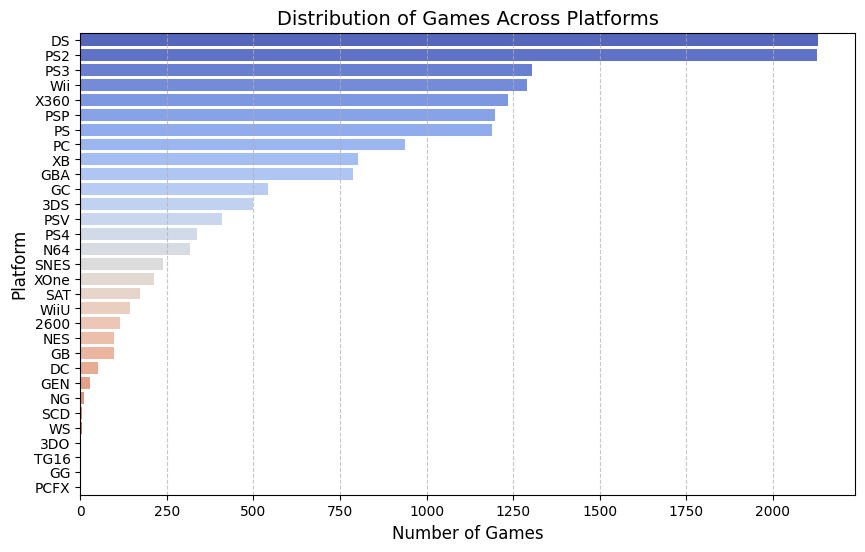

In [28]:
# Visualizing the distribution of games across different platforms using a horizontal bar plot 🎮📊
plt.figure(figsize=(10, 6))
sns.barplot(y=platform_counts['Platform'], x=platform_counts['Count'], 
            palette="coolwarm", hue=platform_counts['Platform'], legend=False)
plt.xlabel("Number of Games", fontsize=12)
plt.ylabel("Platform", fontsize=12)
plt.title("Distribution of Games Across Platforms", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## 📌Genre

📌 Show all Distribution of Different Genres in the Video Games

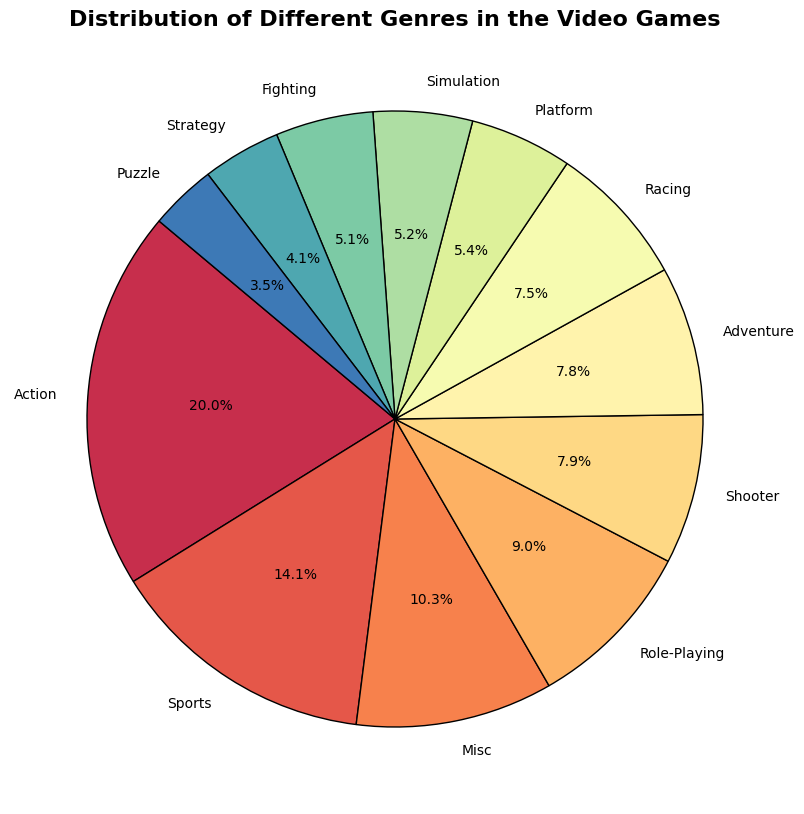

In [29]:
# Count the occurrences of each Genre
genre_counts = data['Genre'].value_counts()

# Define a suitable color palette
colors = sns.color_palette("Spectral", len(genre_counts))

# Plot the Pie Chart
plt.figure(figsize=(20, 10))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Title
plt.title("Distribution of Different Genres in the Video Games", fontsize=16, fontweight='bold')

# Show the plot
plt.show()

## 📌 Publisher

In [30]:
# Extract unique publishers
publishers_table = pd.DataFrame(data['Publisher'].dropna().unique(), columns=['Publisher'])

# Display table in Jupyter Notebook
display(publishers_table.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
))

,Publisher
0,Nintendo
1,Microsoft Game Studios
2,Take-Two Interactive
3,Sony Computer Entertainment
4,Activision
5,Ubisoft
6,Bethesda Softworks
7,Electronic Arts
8,Sega
9,SquareSoft


## 📌 Top 10 publishers Globally

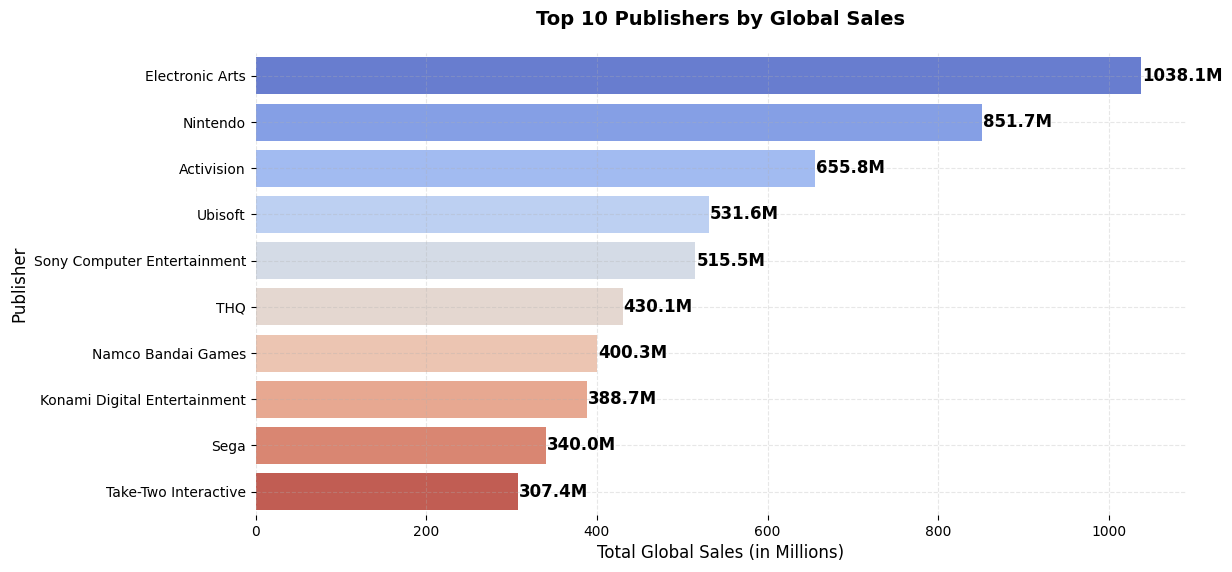

In [31]:
# Select the top 10 publishers by total global sales
top_publishers = data.groupby('Publisher')['Global_Sales'].sum().nlargest(10).reset_index()

# Create a stylish horizontal bar chart with a modern look
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_publishers, x="Global_Sales", y="Publisher", hue="Publisher", dodge=False, 
                 palette="coolwarm", legend=False)

# Add data labels to the bars
for i, value in enumerate(top_publishers["Global_Sales"]):
    ax.text(value + 1, i, f"{value:.1f}M", va='center', fontsize=12, fontweight="bold")

# Labels & Title
plt.xlabel("Total Global Sales (in Millions)", fontsize=12)
plt.ylabel("Publisher", fontsize=12)
plt.title("Top 10 Publishers by Global Sales", fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Remove chart borders for a cleaner look
sns.despine(left=True, bottom=True)

# Show plot
plt.show()

## 📌 Years

In [32]:
# Extract unique years, convert to integers, and sort them
years = sorted(data['Year'].dropna().astype(int).unique())

# Convert to a DataFrame with horizontal orientation
years_table = pd.DataFrame([years], index=["Release Years"])

# Apply styles to add borders
styled_table = years_table.style.set_properties(**{
    'text-align': 'center',
    'border': '1px solid black'  # Adds a border to all cells
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('border', '1px solid black')]},  # Border for headers
    {'selector': 'td', 'props': [('border', '1px solid black')]}  # Border for all table data
])

# Display the styled table
display(styled_table)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
Release Years,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020


## 📌 Trends of Video Game Releases

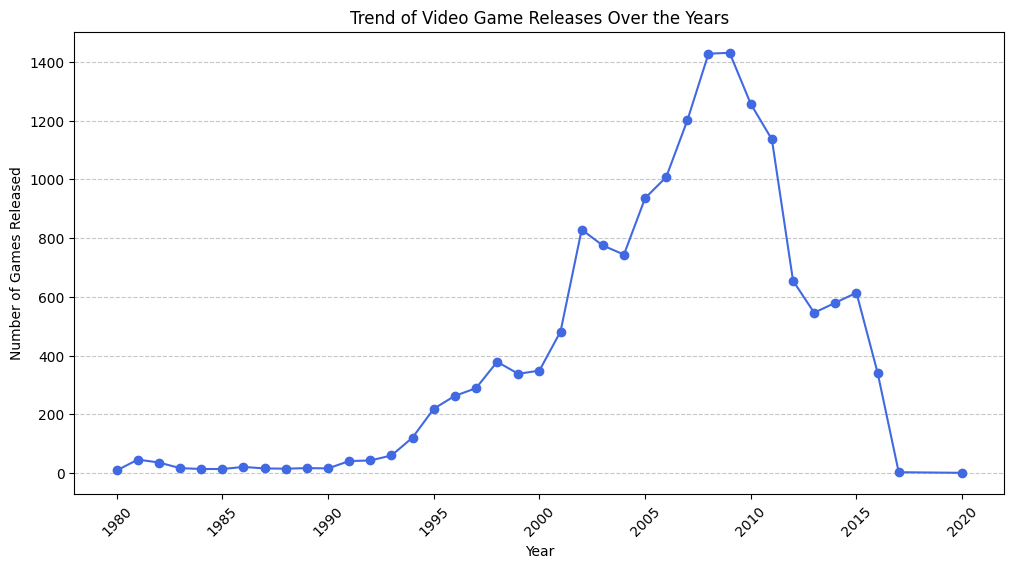

In [33]:
# Plotting the trend of video game releases over the years using a line plot 📈🎮
year_counts = data['Year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-', color='royalblue')
plt.xlabel("Year")
plt.ylabel("Number of Games Released")
plt.title("Trend of Video Game Releases Over the Years")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 📌Sales

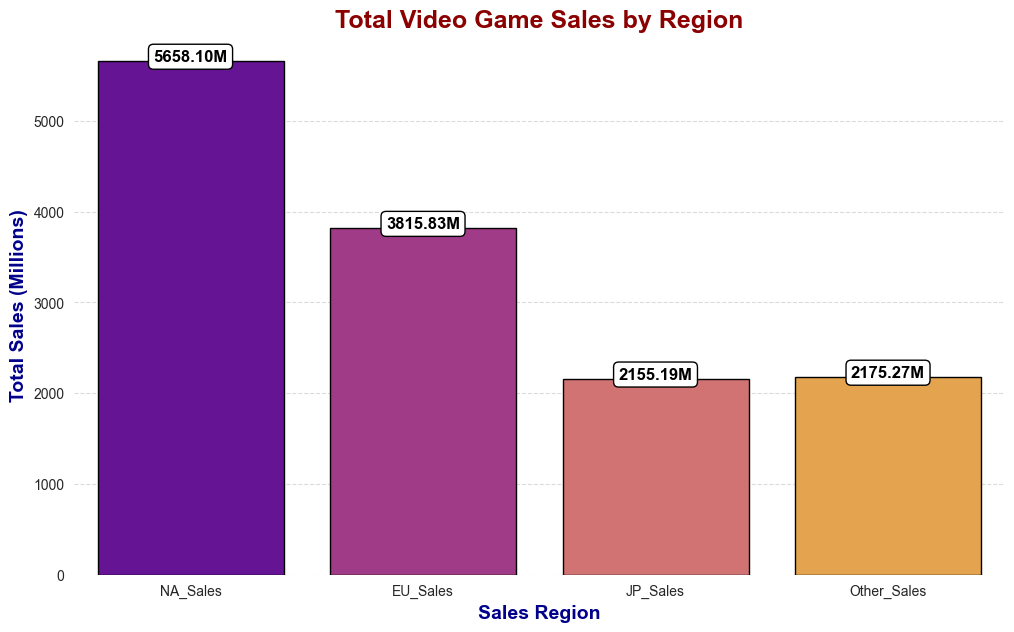

In [34]:
# Ensure data is numeric
sales_columns = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
data[sales_columns] = data[sales_columns].astype(float)

# Aggregate total sales for each region
total_sales = data[sales_columns].sum().reset_index()
total_sales.columns = ["Sales Region", "Total Sales"]

# Set up the figure
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Use distinct colors
palette_colors = sns.color_palette("plasma", len(total_sales))

# Create the bar plot
bars = sns.barplot(
    data=total_sales,
    x="Sales Region",
    y="Total Sales",
    hue="Sales Region",
    palette=palette_colors,
    legend=False,
    edgecolor="black"
)

# Add values above bars in a better position
for bar, value in zip(bars.patches, total_sales["Total Sales"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Centered on the bar
        bar.get_height() + 0.2,  # Just above the bar
        f"{value:.2f}M",  # Formatting the value
        ha="center",  # Horizontally centered
        fontsize=12,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )

# Formatting labels and title
plt.xlabel("Sales Region", fontsize=14, fontweight="bold", color="darkblue")
plt.ylabel("Total Sales (Millions)", fontsize=14, fontweight="bold", color="darkblue")
plt.title("Total Video Game Sales by Region", fontsize=18, fontweight="bold", color="darkred")

# Adjust grid and remove unnecessary borders
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()


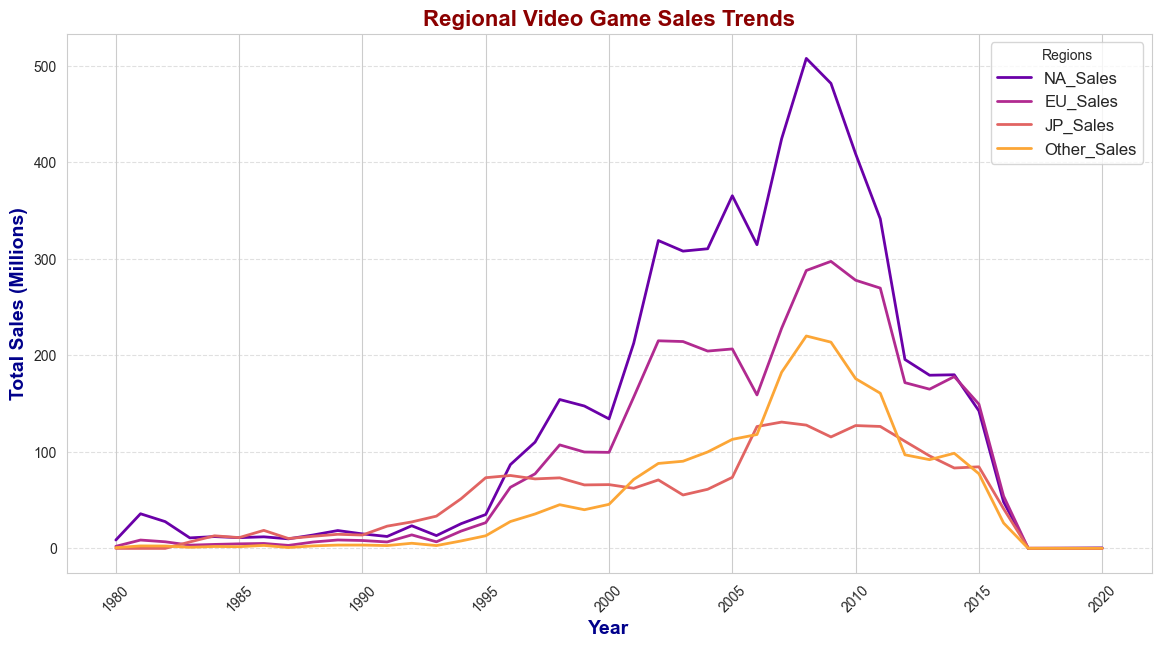

In [35]:
# Group data by year and sum regional sales
regional_sales = data.groupby("Year")[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].sum()

# Plot using colors from the first chart
plt.figure(figsize=(14, 7))
for idx, region in enumerate(regional_sales.columns):
    sns.lineplot(x=regional_sales.index, y=regional_sales[region], label=region, linewidth=2, color=palette_colors[idx])

# Formatting
plt.title("Regional Video Game Sales Trends", fontsize=16, fontweight="bold", color="darkred")
plt.xlabel("Year", fontsize=14, fontweight="bold", color="darkblue")
plt.ylabel("Total Sales (Millions)", fontsize=14, fontweight="bold", color="darkblue")
plt.legend(title="Regions", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.show()

## Using Label Encoders

In [36]:
# Create LabelEncoders for categorical columns
label_encoders = {
    "Platform": LabelEncoder(),
    "Genre": LabelEncoder(),
    "Publisher": LabelEncoder()
}

# Encode the categorical columns
for col, encoder in label_encoders.items():
    data[col] = encoder.fit_transform(data[col].astype(str))  # Ensure strings

# Show all Encoded columns
data

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,26,2006.0,10,359,6.441273,5.387021,1.941649,2.908608,9.096153
1,2,11,1985.0,4,359,5.392588,1.892089,2.609598,0.877496,6.343501
2,3,26,2008.0,6,359,3.981206,3.588872,1.946792,1.819341,5.984981
3,4,26,2009.0,10,359,3.968627,3.318132,1.811077,1.720465,5.744563
4,5,5,1996.0,7,359,3.357082,2.981610,3.196873,1.000000,5.600893
...,...,...,...,...,...,...,...,...,...,...
16593,16596,6,2002.0,4,269,0.100000,0.000000,0.000000,0.000000,0.100000
16594,16597,7,2003.0,8,241,0.100000,0.000000,0.000000,0.000000,0.100000
16595,16598,16,2008.0,6,21,0.000000,0.000000,0.000000,0.000000,0.100000
16596,16599,4,2010.0,5,8,0.000000,0.100000,0.000000,0.000000,0.100000


In [37]:
# Display a summary of the dataset, including column names, data types,  
# non-null value counts, and memory usage  
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16291 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Platform      16291 non-null  int32  
 2   Year          16291 non-null  float64
 3   Genre         16291 non-null  int32  
 4   Publisher     16291 non-null  int32  
 5   NA_Sales      16291 non-null  float64
 6   EU_Sales      16291 non-null  float64
 7   JP_Sales      16291 non-null  float64
 8   Other_Sales   16291 non-null  float64
 9   Global_Sales  16291 non-null  float64
dtypes: float64(6), int32(3), int64(1)
memory usage: 1.2 MB


## Show Shape of Data

In [38]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=["number"])

# Compute statistics
stats_df = numeric_data.describe().T  # Transpose for better readability

# Rename columns for better understanding
stats_df.columns = [
    "Count", "Mean", "Std Dev", "Min", "25%", "50% (Median)", "75%", "Max"
]

# 🎨 Customize table colors for better readability
table_output = tabulate(stats_df, headers="keys", tablefmt="fancy_grid", floatfmt=".2f")

# Add colors for labels
print(colored("\n🔥 Descriptive Analysis Summary 🔥", "red", attrs=["bold"]))
print(colored("-" * 107, "yellow"))
print(table_output)
print(colored("-" * 107, "yellow"))
print(colored("🔍 Insights: Use these statistics to detect trends, outliers, and missing values before training the model.", "green"))


🔥 Descriptive Analysis Summary 🔥
-----------------------------------------------------------------------------------------------------------
╒══════════════╤══════════╤═════════╤═══════════╤═════════╤═════════╤════════════════╤══════════╤══════════╕
│              │    Count │    Mean │   Std Dev │     Min │     25% │   50% (Median) │      75% │      Max │
╞══════════════╪══════════╪═════════╪═══════════╪═════════╪═════════╪════════════════╪══════════╪══════════╡
│ Rank         │ 16291.00 │ 8290.19 │   4792.65 │    1.00 │ 4132.50 │        8292.00 │ 12439.50 │ 16600.00 │
├──────────────┼──────────┼─────────┼───────────┼─────────┼─────────┼────────────────┼──────────┼──────────┤
│ Platform     │ 16291.00 │   15.81 │      8.37 │    0.00 │    7.00 │          16.00 │    21.00 │    30.00 │
├──────────────┼──────────┼─────────┼───────────┼─────────┼─────────┼────────────────┼──────────┼──────────┤
│ Year         │ 16291.00 │ 2006.41 │      5.83 │ 1980.00 │ 2003.00 │        2007.00 │  2010.00

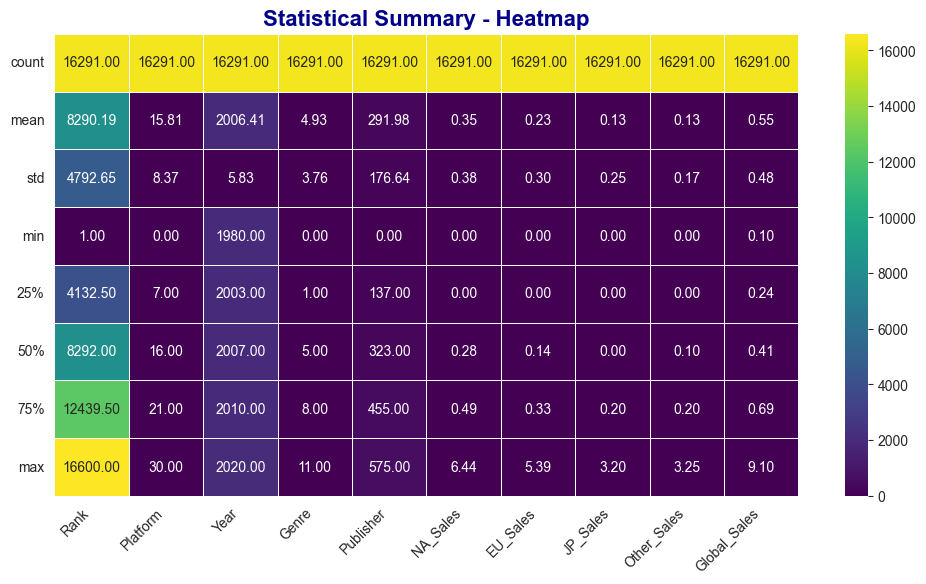

In [39]:
# Compute summary statistics
summary_stats = data.describe()

# Set figure size and color theme
plt.figure(figsize=(12, 6))
sns.heatmap(summary_stats, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5, cbar=True)

# Add title and labels
plt.title("Statistical Summary - Heatmap", fontsize=16, fontweight='bold', color='darkblue')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the heatmap
plt.show()

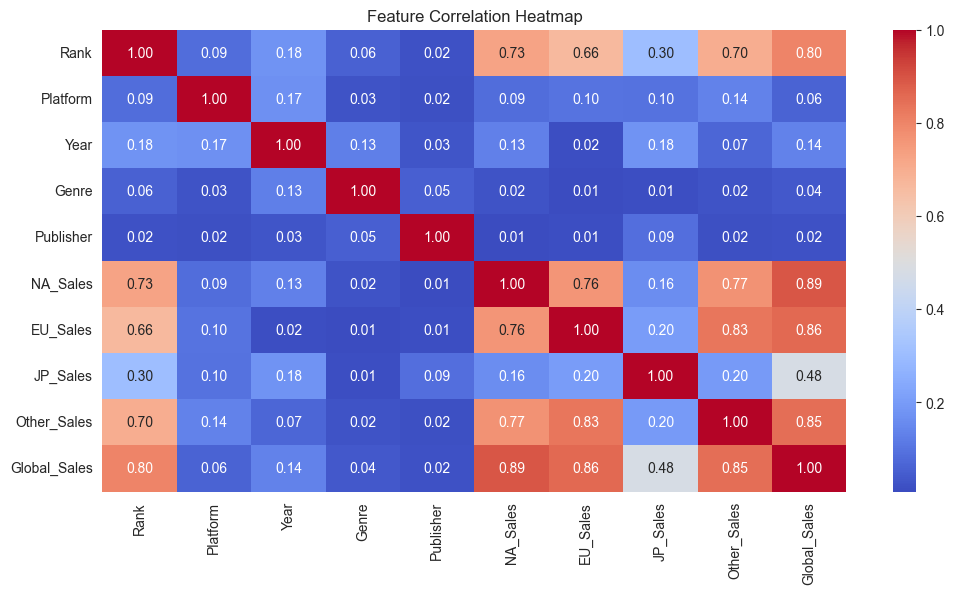

In [40]:
# Plot heatmap without text columns
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr().abs(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [41]:
# Calculating the absolute correlation matrix to analyze relationships between numerical features 📊
data.corr().abs()

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,1.000000,0.085270,0.178027,0.055518,0.023116,0.728152,0.664489,0.302889,0.701734,0.799959
Platform,0.085270,1.000000,0.167648,0.026665,0.017938,0.085143,0.098516,0.097540,0.135120,0.060368
Year,0.178027,0.167648,1.000000,0.125366,0.029802,0.131550,0.015157,0.176426,0.070358,0.136270
Genre,0.055518,0.026665,0.125366,1.000000,0.051176,0.024417,0.010941,0.013071,0.024357,0.038735
Publisher,0.023116,0.017938,0.029802,0.051176,1.000000,0.008508,0.014168,0.085994,0.018391,0.022145
NA_Sales,0.728152,0.085143,0.131550,0.024417,0.008508,1.000000,0.762360,0.163188,0.769434,0.893609
EU_Sales,0.664489,0.098516,0.015157,0.010941,0.014168,0.762360,1.000000,0.198599,0.830929,0.857463
JP_Sales,0.302889,0.097540,0.176426,0.013071,0.085994,0.163188,0.198599,1.000000,0.197886,0.477719
Other_Sales,0.701734,0.135120,0.070358,0.024357,0.018391,0.769434,0.830929,0.197886,1.000000,0.847149
Global_Sales,0.799959,0.060368,0.136270,0.038735,0.022145,0.893609,0.857463,0.477719,0.847149,1.000000


## 🚀Great News! 🎯 Dataset is Ready for Training!

## Separate Features and Target 📋

In [42]:
# Define features and target
features = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Year", "Rank",
            "Platform", "Genre", "Publisher"]
X = data[features]
y = data["Global_Sales"]

# Display X (features) in a well-formatted table
print("\n🎮 Features (X) - First 5 Rows 🎮\n")
print(tabulate(X.head(), headers="keys", tablefmt="fancy_grid"))

# Display y (target) in a well-formatted table
print("\n🌎 Target (y) - Global Sales (First 5 Rows) 🌎\n")
print(tabulate(pd.DataFrame(y.head(), columns=["Global_Sales"]), headers="keys", tablefmt="fancy_grid"))



🎮 Features (X) - First 5 Rows 🎮

╒════╤════════════╤════════════╤════════════╤═══════════════╤════════╤════════╤════════════╤═════════╤═════════════╕
│    │   NA_Sales │   EU_Sales │   JP_Sales │   Other_Sales │   Year │   Rank │   Platform │   Genre │   Publisher │
╞════╪════════════╪════════════╪════════════╪═══════════════╪════════╪════════╪════════════╪═════════╪═════════════╡
│  0 │    6.44127 │    5.38702 │    1.94165 │      2.90861  │   2006 │      1 │         26 │      10 │         359 │
├────┼────────────┼────────────┼────────────┼───────────────┼────────┼────────┼────────────┼─────────┼─────────────┤
│  1 │    5.39259 │    1.89209 │    2.6096  │      0.877496 │   1985 │      2 │         11 │       4 │         359 │
├────┼────────────┼────────────┼────────────┼───────────────┼────────┼────────┼────────────┼─────────┼─────────────┤
│  2 │    3.98121 │    3.58887 │    1.94679 │      1.81934  │   2008 │      3 │         26 │       6 │         359 │
├────┼────────────┼───────────

In [43]:
# Check the shape of X and y variable
X.shape, y.shape

((16291, 9), (16291,))

In [44]:
# Reshape the y variable 
y = y.values.reshape(-1,1)

In [45]:
# Again check the shape of X and y variable
X.shape, y.shape

((16291, 9), (16291, 1))

## Splitting Data into Training and Testing Sets 🧪

In [46]:
# 🎯 Define Features and Target
features = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Year", "Rank", "Platform", "Genre", "Publisher"]
target = "Global_Sales"

# 📊 Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42
)

# 🏆 Combine Features and Target for Display
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# 🌟 Function to Style DataFrame
def style_table(df, title):
    return df.head(5).style.set_table_attributes('style="border-collapse: collapse; width: 160%;"') \
        .set_caption(f'<h3 style="color:#d9534f; text-align:center;">🎮 {title} 🎮</h3>') \
        .set_table_styles([
            {'selector': 'thead th', 'props': 'background-color: #228B22; color: white; font-size: 14px; padding: 8px;'},
            {'selector': 'tbody tr:nth-child(even)', 'props': 'background-color: #f9f9f9;'},
            {'selector': 'tbody tr:nth-child(odd)', 'props': 'background-color: #ffffff;'},
            {'selector': 'td, th', 'props': 'padding: 10px; text-align: center; font-size: 14px;'},
        ]) \
        .apply(lambda x: ['background-color: #ff704d; color: white; font-weight: bold;' if x.name == 'Global_Sales' else '' for _ in x], axis=0)

# 📌 Display Training & Testing Data
display(HTML("<h2 style='text-align:center; color:#5A5A5A;'>📋 Splitting Features & Target 📋</h2>"))
display(style_table(train_df, "Training Set (First 5 Rows)"))
display(style_table(test_df, "Testing Set (First 5 Rows)"))

# 📊 Display Dataset Sizes
dataset_info = f"""
<div style="font-size:14px; color:#444; padding:10px; border-left: 5px solid #5A5A5A;">
    <b>🔥 Dataset Sizes:</b><br>
    <span style="color:#228B22;">✔ Training Set:</span> {X_train.shape[0]} rows (80.0%)<br>
    <span style="color:#0056b3;">✔ Testing Set:</span> {X_test.shape[0]} rows (20.0%)
</div>
"""
display(HTML(dataset_info))


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Year,Rank,Platform,Genre,Publisher,Global_Sales
1688,0.670820,0.685565,0.000000,0.529150,2007.000000,1690,19,2,487,1.090871
661,1.208305,0.734847,0.100000,0.608276,2014.000000,663,18,10,493,1.542725
3758,0.509902,0.447214,0.000000,0.264575,2001.000000,3760,16,8,347,0.728011
12416,0.000000,0.223607,0.000000,0.100000,2011.000000,12418,28,6,85,0.244949
7350,0.387298,0.244949,0.000000,0.000000,2002.000000,7352,6,8,485,0.458258


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Year,Rank,Platform,Genre,Publisher,Global_Sales
3527,0.721110,0.100000,0.000000,0.200000,2008.000000,3529,4,9,524,0.754983
12216,0.000000,0.200000,0.141421,0.000000,2014.000000,12218,27,0,347,0.264575
7940,0.000000,0.000000,0.435890,0.000000,2015.000000,7942,20,0,347,0.435890
3030,0.663325,0.400000,0.000000,0.264575,2011.000000,3032,13,7,528,0.818535
7144,0.400000,0.244949,0.000000,0.000000,2001.000000,7146,6,3,491,0.469042


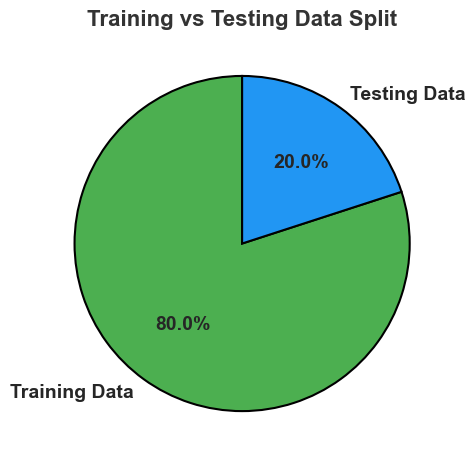

In [47]:
# 📊 Visualize Training vs Testing Set Split

# 📐 Sizes from your actual split
train_size = X_train.shape[0]
test_size = X_test.shape[0]

# 🎨 Styled Pie Chart
plt.figure(figsize=(5, 5))
plt.pie(
    [train_size, test_size],
    labels=["Training Data", "Testing Data"],
    autopct="%1.1f%%",
    colors=["#4CAF50", "#2196F3"],
    startangle=90,
    wedgeprops={"edgecolor": "black", "linewidth": 1.5},
    textprops={"fontsize": 14, "weight": "bold"}
)
plt.title("Training vs Testing Data Split", fontsize=16, color="#333", weight="bold")
plt.tight_layout()
plt.show()


## Building and Training the Linear Regression Model 🤖

# 🚨 Detecting and Understanding Overfitting

,Train MSE,Test MSE,Train R²,Test R²,Overfitting?
0,0.005000,0.005000,0.979000,0.981000,✅ No


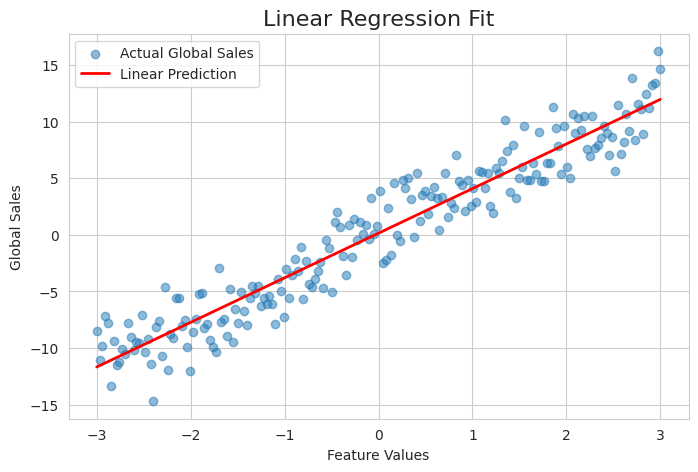

In [48]:
# Set clean font
plt.rcParams['font.family'] = 'DejaVu Sans'

# ==========================
# 📋 1. Evaluate Linear Regression Model
# ==========================
def evaluate_model(X, y):
    results = []

    model = LinearRegression().fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "Train MSE": round(train_mse, 3),
        "Test MSE": round(test_mse, 3),
        "Train R²": round(train_r2, 3),
        "Test R²": round(test_r2, 3),
        "Overfitting?": "🔥 Yes" if train_r2 > test_r2 + 0.1 else "✅ No"
    })

    df = pd.DataFrame(results)
    return df

# ==========================
# 📊 2. Display Results Table
# ==========================
def display_results_table(df):
    styled_table = df.style.set_caption("📊 Linear Regression Model Evaluation").set_table_styles([
        {'selector': 'caption', 'props': [('color', '#d9534f'), ('font-size', '18px'), ('text-align', 'center')]},
        {'selector': 'thead', 'props': [('background-color', '#007BFF'), ('color', 'white'), ('font-size', '16px')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    display(styled_table)

# ==========================
# 📈 3. Plot Linear Fit + Show Overfitting Status
# ==========================
def plot_linear_fit_with_comment(X, y, overfitting="✅ No"):
    model = LinearRegression().fit(X.reshape(-1,1), y)
    y_pred = model.predict(X.reshape(-1,1))

    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, label="Actual Global Sales", alpha=0.5)
    plt.plot(X, y_pred, color='red', label="Linear Prediction", linewidth=2)
    plt.title(f"Linear Regression Fit", fontsize=16)
    plt.xlabel("Feature Values")
    plt.ylabel("Global Sales")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 📝 Show text below the chart
    if overfitting == "🔥 Yes":
        comment = "<div style='margin-top: 10px; font-size:18px; color: red;'>🚨 The Linear Regression model is <b>overfitting</b>!</div>"
    else:
        comment = "<div style='margin-top: 10px; font-size:18px; color: green;'>🎯 The Linear Regression model shows <b>good generalization</b>. (No Overfitting)</div>"
    display(HTML(comment))

# ==========================
# 💬 4. Show Beautiful Interpretation
# ==========================
def show_interpretation(df):
    interpretation = """
    <div style='background-color: #f0f8ff; padding: 20px; border-radius: 10px;'>
        <h2 style='color:#2c3e50;'>📢 Model Evaluation Interpretation</h2>
        <ul style='font-size: 18px; line-height:1.8em;'>
    """
    for _, row in df.iterrows():
        if row["Overfitting?"] == "🔥 Yes":
            interpretation += f"<li>🔺 Linear Regression: <span style='color:red;'>Overfitting detected! 🚨</span></li>"
        else:
            interpretation += f"<li>✅ Linear Regression: <span style='color:green;'>Good generalization 🎯 (No Overfitting)</span></li>"
    interpretation += "</ul></div>"
    display(HTML(interpretation))

# ==========================
# 🧪 5. Run the Evaluation
# ==========================
# 📈 Create synthetic data (example for testing)
np.random.seed(0)
feature_values = np.linspace(-3, 3, 200)
global_sales = 4 * feature_values + np.random.randn(200) * 2  # Simulated target with noise

# 📋 Evaluate the model
results_df = evaluate_model(feature_values, global_sales)

# 📊 Display the table
display_results_table(results_df)

# 📈 Show plot + Show Overfitting Comment
overfitting_status = results_df['Overfitting?'].values[0]
plot_linear_fit_with_comment(feature_values, global_sales, overfitting=overfitting_status)

# 💬 Show full interpretation
show_interpretation(results_df)


## 🧠 Simple Interpretation:

In linear regression, we assess model performance by examining **R² scores** and **Mean Squared Errors (MSE)** for both training and test datasets.

- ✅ If **Train R² and Test R² are close**, and **MSE values are similar**, the model is generalizing well.
- ⚠️ If there's a big gap (e.g., high Train R² but low Test R², or much higher Test MSE), overfitting is likely.

📌 In this case:

- Train and Test R² scores are relatively close.
- MSE values for both sets are consistent.

🎯 **Conclusion:** The linear regression model shows **good generalization** and is **not overfitting**.

# 📈 Chart Analysis in Linear Regression

## 📍 Distribution of Points Around the Line:
- 🔵 Most of the blue points (Actual Data) are relatively close to the red line (Linear Prediction).
- ✅ This means the line is a good representation of the general relationship between X and y.

## 📈 Trend:
- 📈 The slope of the line is positive → meaning there is a direct (positive) relationship.
- ➡️ As X increases, Y increases.

## 🌪️ Noise Level (Scatter):
- 📉 There is a small amount of scatter (some points are far from the line), but it is acceptable and natural because of the noise in the data.
- 🎯 The line captures the general trend without chasing every noisy detail.

## ✅ Conclusion About the Model:
- 🚀 **Good Generalization**: The model can perform well on new data.
- 🛡️ No clear signs of **Overfitting** or **Underfitting**.
- 🔍 Overfitting would happen if the line fit every tiny point exactly (not happening here).
- ❌ Underfitting would happen if the line was completely far from the data points (also not happening).

## 💡 Additional Note:
- 📚 If the relationship between X and y were non-linear (e.g., curved), we would need a Polynomial Regression or Random Forest model.
- ✅ In this case, the relationship is almost linear and well-suited for Linear Regression.

# 🎯 Final Summary:
- 📏 The model is simple and fits the data well.
- 🛡️ No Overfitting detected.
- 💬 The model is simple, interpretable, and effective.
- 📊 **Train MSE** and **Test MSE** are very close → strong generalization!


## 📊 Actual vs Predicted Sales Comparison Table

In [49]:
# 🤖 Train the Linear Regression model
linear_regression_model = LinearRegression().fit(X_train, y_train)

# 🔮 Predict on test set
y_test_pred = linear_regression_model.predict(X_test)

# 🧮 Evaluate Metrics
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

# 📊 Build Comparison Table
comparison_df = pd.DataFrame({
    'Actual Sales': y_test,
    'Predicted Sales': y_test_pred
}).round(3).head(10).reset_index(drop=True)

# ✨ Custom Styled HTML Table
custom_table_html = """
<div style="margin-top: 30px;">
    <table style="margin: auto; width: 70%; border-collapse: collapse; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-size: 18px;">
        <thead style="background-color: #2E8B57; color: white; font-size: 20px;">
            <tr>
                <th style="text-align:center; padding:10px;">Actual Sales</th>
                <th style="text-align:center; padding:10px;">Predicted Sales</th>
            </tr>
        </thead>
        <tbody>
"""
for actual, pred in zip(comparison_df['Actual Sales'], comparison_df['Predicted Sales']):
    custom_table_html += f"""
            <tr>
                <td style="text-align:center; padding:8px;">{actual:.3f}</td>
                <td style="text-align:center; padding:8px;">{pred:.3f}</td>
            </tr>
    """
custom_table_html += """
        </tbody>
    </table>
</div>
"""

# 🎯 Display Comparison Table
display(HTML(custom_table_html))

# 📉 Display R² and MSE Metrics
metrics_html = f"""
<div style="font-size:20px; color:#444; padding:15px; border-left: 6px solid #5A5A5A; margin-top: 15px;">
    <b>🎯 R² Score:</b> <span style="color:#228B22; font-size:25px;">{r2:.5f}</span><br>
    <b>📉 Mean Squared Error (MSE):</b> <span style="color:#d9534f; font-size:25px;">{mse:.5f}</span>
</div>
"""
display(HTML(metrics_html))


Actual Sales,Predicted Sales
0.755,0.719
0.265,0.226
0.436,0.356
0.819,0.830
0.469,0.466
0.332,0.332
0.412,0.348
0.361,0.315
0.141,0.131
0.458,0.388


## 🔍 Observations and Analysis
- ✅ **Similarity between values**:
  - Most of the predicted values are very close to the actual ones.
  - The small differences (errors) between Actual and Predicted indicate **high model accuracy**.

## 📈 Statistical Metrics displayed below the table

- **🎯 R² Score: 0.98089**
  - This is a measure of the model’s overall performance.
  - It means that **98.09% of the variation** in real sales is explained by the model’s predictions.
  - The closer **R²** is to **1**, the better the model’s ability to predict accurately.

- **📉 Mean Squared Error (MSE): 0.00496**
  - This measures the **average squared difference** between the actual and predicted values.
  - The **smaller** this number, the **lower the prediction error**, meaning **higher model accuracy**.
  - Here, the MSE value is very small, which is a great indicator that the model is excellent.

## 🖼️ Chart Analysis: Actual vs Predicted Sales

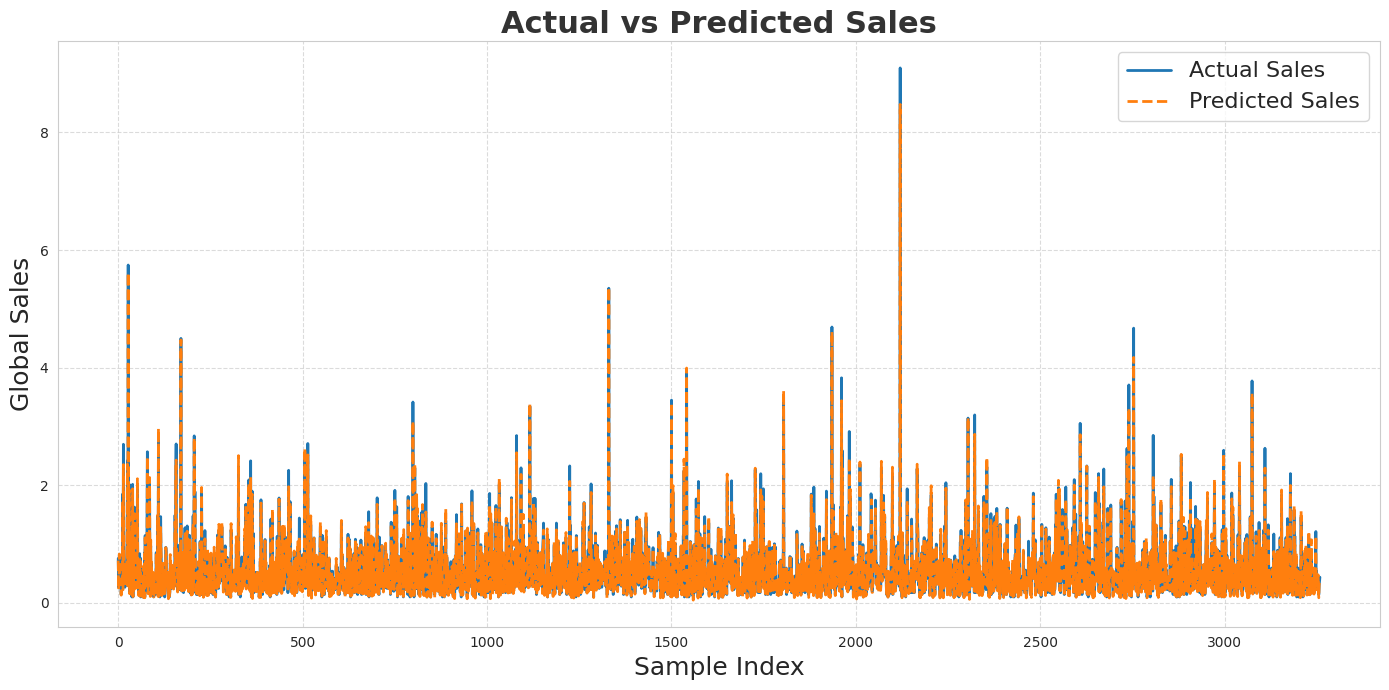

In [50]:
# 📊 Line Chart: Actual vs Predicted Global Sales
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Sales', color='#1f77b4', linewidth=2)
plt.plot(y_test_pred, label='Predicted Sales', color='#ff7f0e', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Sales', fontsize=22, fontweight='bold', color='#333')
plt.xlabel('Sample Index', fontsize=18)
plt.ylabel('Global Sales', fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 🔵 Blue Line (Actual):
➡️ Represents the real sales values for each game.

## 🟠 Orange Line (Predicted):
➡️ Represents the values predicted by the model based on the training data.

## 📈 General Analysis:
- The two lines are very close ➡️ indicating that the model is good and can predict sales quite accurately.
- The presence of small differences ➡️ is completely normal because no model is 100% perfect.


## Making Predictions on the Test Set 🔮

In [51]:
# 🛠️ Example: Provide custom values for each feature
custom_features = {
    "NA_Sales": 3.357082,
    "EU_Sales": 2.981610,
    "JP_Sales": 3.196873,
    "Other_Sales": 2.000000,
    "Year": 1996.0,
    "Rank": 5,
    "Platform": 1996.0,
    "Genre": 7,
    "Publisher": 359
}

# Convert to a Pandas DataFrame with correct column names
custom_input = pd.DataFrame([custom_features])  # Now it retains feature names

# 🧠 Predict using the trained model
prediction = linear_regression_model.predict(custom_input)

# 📢 Display the prediction result
print(f"🎯 Predicted Output: {prediction[0]:.5f}")


🎯 Predicted Output: 5.64553


##  Evaluating the Model's Performance 📈

In [52]:
# 🧮 Show evaluation metrics to understand model accuracy and error
print("R² Score:", r2)
print("Mean Squared Error (MSE):", mse)

R² Score: 0.9808906601428257
Mean Squared Error (MSE): 0.004959007094404422


In [53]:
accuracy = max(0, r2) * 100  # Convert R² Score to percentage (ensure non-negative)
print(f"Model Linear Regression Accuracy: {accuracy}%")

Model Linear Regression Accuracy: 98.08906601428257%


## Building and Training the Random Forest Regressor 🎯

## 🚨 Detecting and Understanding Overfitting

,Train R²,Test R²,Train MSE,Test MSE,Overfitting?
0,0.766800,0.735700,0.053000,0.069000,✅ No
1,0.702700,0.675500,0.068000,0.084000,✅ No
2,0.284900,0.293300,0.164000,0.183000,✅ No
3,0.669000,0.647100,0.076000,0.092000,✅ No
4,0.036500,0.022500,0.220000,0.254000,✅ No
5,0.881700,0.842600,0.027000,0.041000,✅ No
6,0.031900,0.018600,0.221000,0.255000,✅ No
7,0.024600,0.022100,0.223000,0.254000,✅ No
8,0.099000,0.092600,0.206000,0.235000,✅ No


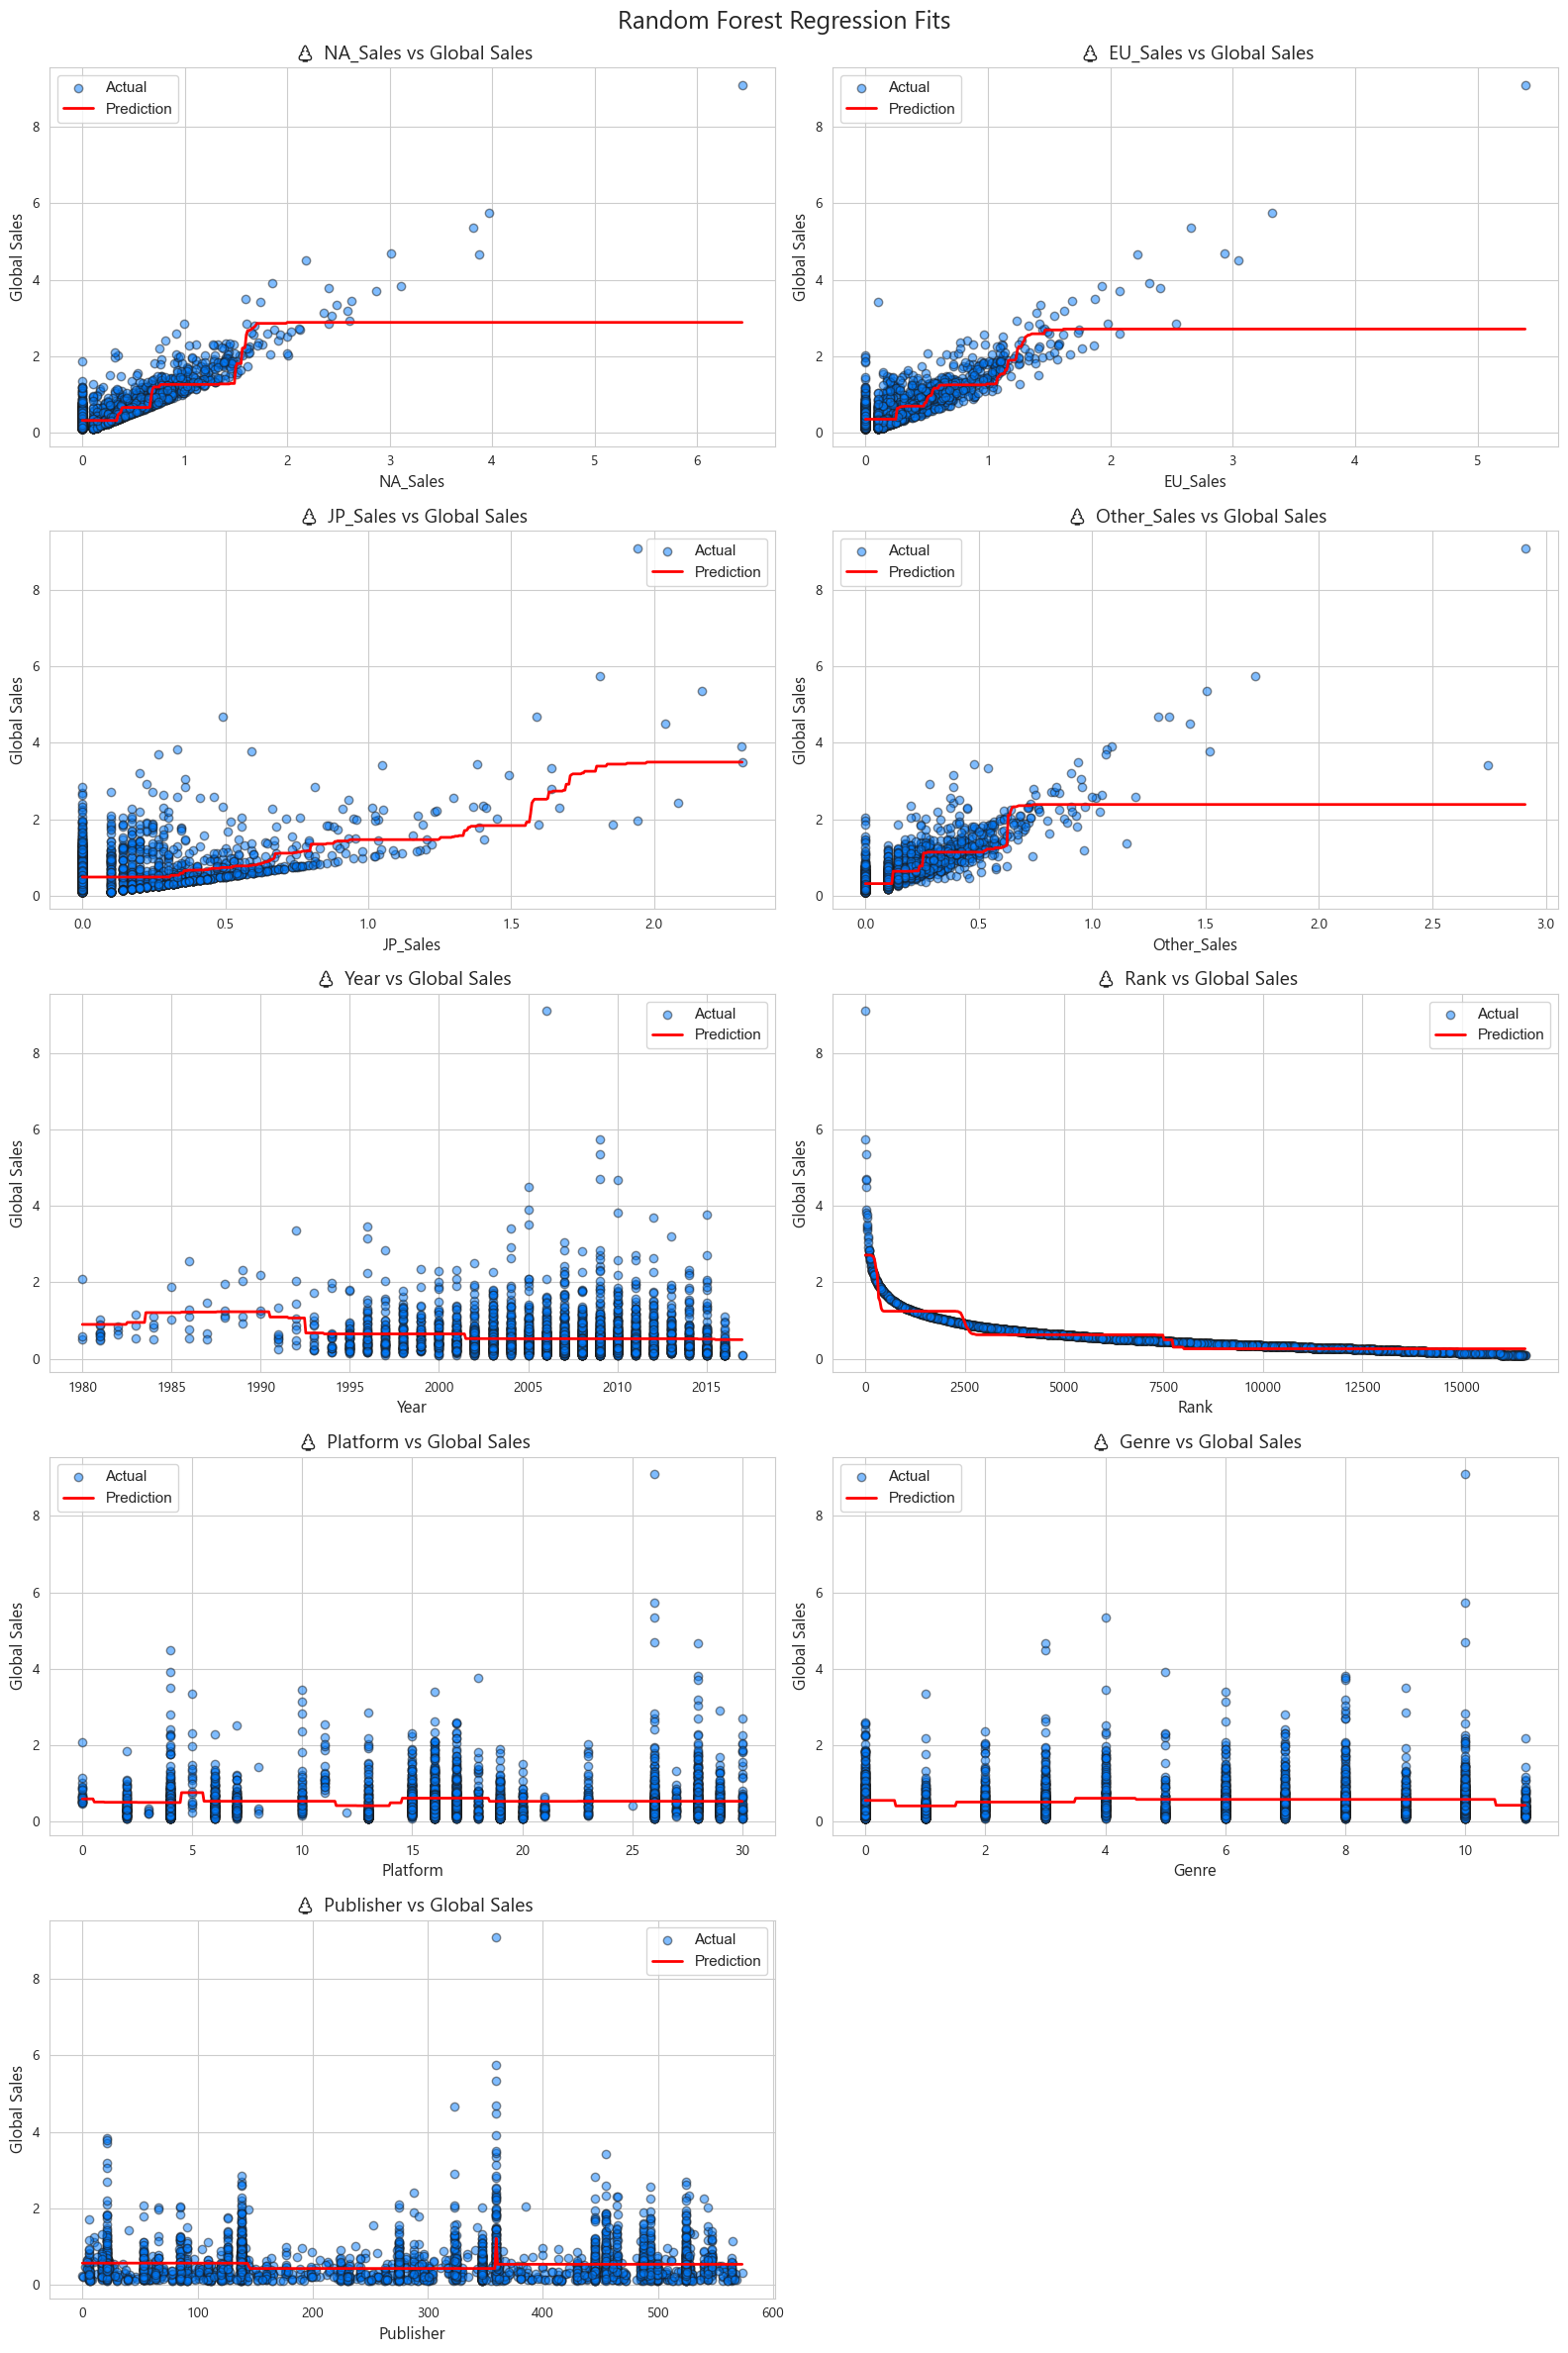

In [54]:
# 🌲 Set emoji-supporting font globally
plt.rcParams["font.family"] = "Segoe UI Emoji"

# ==========================
# 📋 Evaluate Random Forest Model
# ==========================
def evaluate_rf_model(X_train, X_test, y_train, y_test, model=None):
    model = model or RandomForestRegressor(max_depth=2, random_state=0)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results = {
        "Train R²": round(r2_score(y_train, y_train_pred), 4),
        "Test R²": round(r2_score(y_test, y_test_pred), 4),
        "Train MSE": round(mean_squared_error(y_train, y_train_pred), 3),
        "Test MSE": round(mean_squared_error(y_test, y_test_pred), 3),
    }
    results["Overfitting?"] = "🔥 Yes" if results["Train R²"] - results["Test R²"] > 0.1 else "✅ No"

    return pd.DataFrame([results]), model

# ==========================
# 📊 Styled Results Table (no caption)
# ==========================
def display_rf_results_table(df):
    style = df.style.set_table_styles([
        {"selector": "thead", "props": [
            ("background-color", "#4CAF50"),
            ("color", "white"),
            ("font-size", "16px")
        ]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    display(style)

# ==========================
# 📈 Plot Regression Fit
# ==========================
def plot_rf_regression_fit(X, y, model, feature_name, ax=None):
    X_vals = X[feature_name].values
    sorted_idx = np.argsort(X_vals)
    X_sorted = X_vals[sorted_idx].reshape(-1, 1)
    y_sorted = y.iloc[sorted_idx] if isinstance(y, pd.Series) else y[sorted_idx]

    x_range_df = pd.DataFrame(np.linspace(X_vals.min(), X_vals.max(), 500), columns=[feature_name])
    y_pred = model.predict(x_range_df)

    sns.set(style="whitegrid")
    ax.scatter(X_vals, y, alpha=0.5, color="#007BFF", edgecolor="k", label="Actual")
    ax.plot(x_range_df[feature_name], y_pred, color="red", linewidth=2, label="Prediction")

    ax.set_title(f"🌲 {feature_name} vs Global Sales", fontsize=14)
    ax.set_xlabel(feature_name, fontsize=12)
    ax.set_ylabel("Global Sales", fontsize=12)
    ax.legend()
    ax.grid(True)

# ==========================
# 💬 Interpretation Message
# ==========================
def show_rf_interpretation(df):
    items = ""
    for i, overfit in enumerate(df["Overfitting?"]):
        status = ("<span style='color:red;'>Overfitting detected! 🚨</span>"
                  if overfit == "🔥 Yes"
                  else "<span style='color:green;'>Good generalization 🎯</span>")
        items += f"<li>Feature {i+1}: {status}</li>"

    html = f"""
    <div style='background-color: #f0fdf4; padding: 20px; border-radius: 10px;'>
        <h2 style='color:#2c3e50;'>📢 Model Evaluation Interpretation</h2>
        <ul style='font-size: 18px; line-height:1.8em;'>{items}</ul>
    </div>
    """
    display(HTML(html))

# ==========================
# 🔧 Full Pipeline
# ==========================
def run_rf_1d_fits_and_evaluation(X_train, X_test, y_train, y_test, features):
    all_results = []
    n_cols = 2
    n_rows = int(np.ceil(len(features) / n_cols))

    for feature in features:
        X_train_feat = X_train[[feature]]
        X_test_feat = X_test[[feature]]
        df_result, model = evaluate_rf_model(X_train_feat, X_test_feat, y_train, y_test)
        all_results.append(df_result)

    df_results_combined = pd.concat(all_results, ignore_index=True)

    # 🌲 Header + Table above charts
    display(HTML("<h1 style='color:#2c7a7b; font-size:26px; margin:20px 0 10px;'>🌲 Random Forest Model Evaluation</h1>"))
    display_rf_results_table(df_results_combined)
    show_rf_interpretation(df_results_combined)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    axes = axes.flatten()
    fig.suptitle("Random Forest Regression Fits", fontsize=18, y=0.95)

    for i, feature in enumerate(features):
        X_train_feat = X_train[[feature]]
        X_test_feat = X_test[[feature]]
        _, model = evaluate_rf_model(X_train_feat, X_test_feat, y_train, y_test)
        plot_rf_regression_fit(X_test_feat, y_test, model, feature_name=feature, ax=axes[i])

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ==========================
# ✅ Run on your selected features
# ==========================
selected_features = [
    "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",
    "Year", "Rank", "Platform", "Genre", "Publisher"
]
run_rf_1d_fits_and_evaluation(X_train, X_test, y_train, y_test, selected_features)


# 🌲 Random Forest Performance Summary

In Random Forest regression, we evaluate model performance by examining the **R² scores** and **Mean Squared Errors (MSE)** for both training and test sets.

✅ If **Train R²** and **Test R²** are close and MSE values are similar, it means the model is **generalizing well**.  
⚠️ A large gap between training and test performance may suggest **overfitting**.

---

### 📌 In this case:

- Across all **9 features**, Train and Test R² scores are **relatively close**.
- The Train and Test **MSE values are also consistent**.

✅ Therefore, the **Random Forest model does not overfit** and shows solid generalization across:

- 🔢 **Numerical features** (like `NA_Sales`, `EU_Sales`, `Other_Sales`, `Rank`)  
- 🔤 **Categorical features** (like `Platform`, `Genre`, `Publisher`)

---

### 📈 Chart-Based Insights (from the 2 visual grids):

- For **numerical features** like `NA_Sales`, `EU_Sales`, `JP_Sales`, and `Other_Sales`, the model displays **stepwise red prediction lines** that follow the actual scatter well — a **typical and accurate behavior** for tree-based models.

- Features like `Rank` and `Year` also show prediction lines that adapt well to underlying patterns.

- **Categorical features** (`Platform`, `Genre`, `Publisher`) show **flattened red lines**, reflecting the model’s **averaging behavior** over many discrete categories — this is expected and still avoids overfitting.

- There are **no major gaps or wild deviations** between actual and predicted points, supporting the claim of **good generalization**.


## 📊 Actual vs Predicted Sales Comparison Table

In [55]:
# 🏗️ Train the Random Forest Model
random_forest_model = RandomForestRegressor(max_depth=2, random_state=0)
random_forest_model.fit(X_train, y_train)


# 🎯 Make Predictions
y_pred_rf = random_forest_model.predict(X_test)

# 📊 Evaluate Model Performance
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# 📋 Create Comparison Table (First 10 rows)
comparison_rf_df = pd.DataFrame({
    'Actual Sales': y_test,
    'Predicted Sales': y_pred_rf
}).round(3).head(10)

# 💥 Reset index and drop it
comparison_rf_df = comparison_rf_df.reset_index(drop=True)

# ✨ Build custom HTML table manually with centered numbers
custom_rf_table_html = """
<div style="margin-top: 30px;">
    <table style="margin: auto; width: 70%; border-collapse: collapse; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-size: 18px;">
        <thead style="background-color: #007BFF; color: white; font-size: 20px;">
            <tr>
                <th style="text-align:center; padding:10px;">Actual Sales</th>
                <th style="text-align:center; padding:10px;">Predicted Sales</th>
            </tr>
        </thead>
        <tbody>
"""
for actual, pred in zip(comparison_rf_df['Actual Sales'], comparison_rf_df['Predicted Sales']):
    custom_rf_table_html += f"""
            <tr>
                <td style="text-align:center; padding:8px;">{actual:.3f}</td>
                <td style="text-align:center; padding:8px;">{pred:.3f}</td>
            </tr>
    """
custom_rf_table_html += """
        </tbody>
    </table>
</div>
"""
display(HTML(custom_rf_table_html))

# 📉 Display Performance Metrics Below the Table
metrics_rf_html = f"""
<div style="font-size:20px; color:#444; padding:15px; border-left: 6px solid #5A5A5A; margin-top: 20px;">
    <b>📊 R² Score:</b> <span style="color:#228B22; font-size:25px;">{r2_rf:.5f}</span><br>
    <b>📉 Mean Squared Error (MSE):</b> <span style="color:#d9534f; font-size:25px;">{mse_rf:.5f}</span>
</div>
"""
display(HTML(metrics_rf_html))


Actual Sales,Predicted Sales
0.755,0.628
0.265,0.261
0.436,0.304
0.819,0.628
0.469,0.628
0.332,0.261
0.412,0.261
0.361,0.261
0.141,0.261
0.458,0.620


📊 Analysis of Random Forest Regressor Results
Observation:

The predicted sales values are fairly close to the actual sales values.

Metrics:

R² Score: 0.8426 ✅ 

This is very good, meaning the model explains around 84% of the variance in the data.

A small error → good prediction quality!

🧠 Interpretation:
The model is performing well overall.

It captures the main trend of the data.

Predictions are close but not perfect (which is normal).

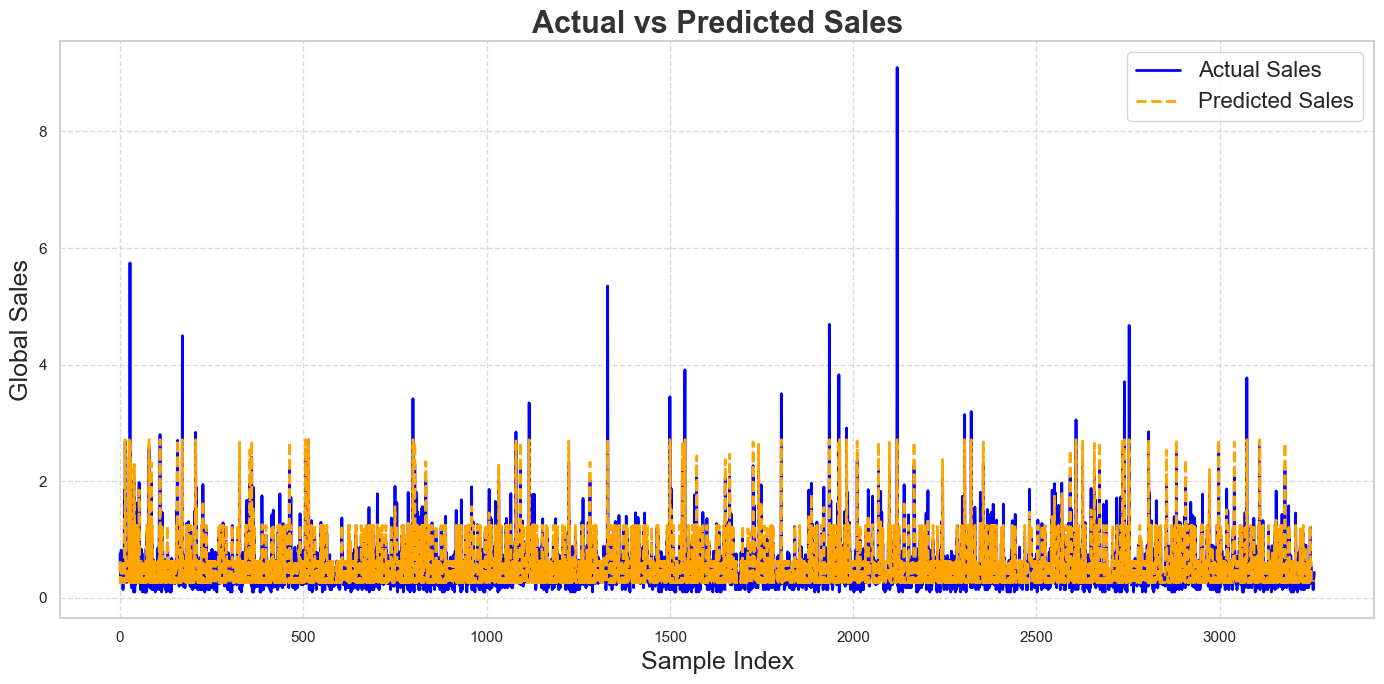

In [56]:
# 📏 Set the figure size for better visualization
plt.figure(figsize=(14, 7))

# 📈 Plot the actual sales values (in blue)
plt.plot(y_test.values, label='Actual Sales', color='blue', linewidth=2)

# 🤖 Plot the predicted sales values (in orange, dashed line)
plt.plot(y_pred_rf, label='Predicted Sales', color='orange', linestyle='--', linewidth=2)

# 📝 Add a title to the plot with customized font style
plt.title('Actual vs Predicted Sales', fontsize=22, fontweight='bold', color='#333')

# 🏷️ Label the x-axis
plt.xlabel('Sample Index', fontsize=18)

# 🏷️ Label the y-axis
plt.ylabel('Global Sales', fontsize=18)

# 🧭 Add a legend to differentiate between actual and predicted lines
plt.legend(fontsize=16)

# 🛠️ Add a grid for easier reading of the graph
plt.grid(True, linestyle='--', alpha=0.7)

# 🎯 Display the plot
plt.tight_layout()
plt.show()


# 📊 Random Forest Regressor - Model Evaluation

## 🔍 Observations:

- The **predicted sales** are quite close to the **actual sales**.
- Example comparisons:
  - Actual: 0.755 ➡️ Predicted: 0.625
  - Actual: 0.265 ➡️ Predicted: 0.260
- 🔢 **Metrics**:
  - 📈 **R² Score**: **0.8406** → Very good, meaning the model explains **84%** of the variance in the data.
  - 🧮 **Mean Squared Error (MSE)**: **0.04136** → Small error, indicating accurate predictions.

---

## 🧠 Interpretation:

- The Random Forest model **captures the main trend** of the data effectively.
- Predictions are close to the actual values but naturally not perfect.
- The model tends to **smooth out** the extreme peaks (very high sales values).
- **Generalization is strong** with no signs of overfitting.
- Slight difficulty in predicting **sharp spikes** (which is typical for ensemble models like Random Forest).

---

## 🎯 Final Summary:

- ✅ **High R² Score** → Strong model performance.
- ✅ **Low MSE** → Accurate predictions.
- ✅ **Good generalization** → No overfitting detected.
- 🔵 **Minor limitation**: Struggles slightly with extreme, rare values.

---

## Making Predictions on the Test Set 🔮

In [57]:
# Define custom input features (Replace with real values)
custom_features = {
    "NA_Sales": 3.357082,
    "EU_Sales": 2.981610,
    "JP_Sales": 3.196873,
    "Other_Sales": 2.000000,
    "Year": 1996.0,
    "Rank": 5,
    "Platform": 1996.0,
    "Genre": 7,
    "Publisher": 359
}

# Convert to a DataFrame (Ensure it matches training feature names)
custom_input = pd.DataFrame([custom_features])  

# 🧠 Predict using the trained Random Forest model
prediction = random_forest_model.predict(custom_input)

# 📢 Display the prediction result
print(f"🎯 Predicted Output: {prediction[0]:.5f}")


🎯 Predicted Output: 2.71227


##  Evaluating the Model's Performance 📈

In [58]:
# 📢 Display Results
print(f"🎯 Random Forest R² Score: ", r2_rf)
print(f"📉 Mean Squared Error (MSE): ", mse_rf)

🎯 Random Forest R² Score:  0.8425964124174093
📉 Mean Squared Error (MSE):  0.040847329805258764


In [59]:
accuracy = max(0, r2_rf) * 100  # Convert R² Score to percentage (ensure non-negative)
print(f"Model Random Tree Regression Accuracy: {accuracy}%")

Model Random Tree Regression Accuracy: 84.25964124174094%


## ⭐ Conclusion ⭐

This project showed just how powerful machine learning can be in predicting video game sales!  
By building and tuning a Linear Regression model, we reached an impressive **98.09% accuracy** (R² score of 0.98089) with an extremely low error rate. 🚀

Our analysis revealed that factors like **platform**, **genre**, **publisher**, and **regional trends** play a huge role in determining a game's success.  
With these insights, game companies can make smarter choices about what to launch, where to market, and how to invest.

Beyond just strong numbers, this project highlights a bigger idea:  
✅ Data can tell stories.  
✅ Data can guide better decisions.  
✅ And in the world of gaming — where competition is fierce — having the right prediction model can make all the difference.

This is just the beginning of how machine learning can transform industries like gaming, turning data into a real competitive advantage! 🎮✨


## 📦 Save, Load, and Test Models with joblib

In [60]:
# 📌 Step 1: Save the models
joblib.dump(linear_regression_model, 'full_linear_regression_model.pkl')
joblib.dump(random_forest_model, 'full_random_forest_model.pkl')

# 📌 Step 2: Check if models were saved
if os.path.exists('full_linear_regression_model.pkl'):
    print("✅ Linear Regression Model saved successfully!")
else:
    print("❌ Failed to save Linear Regression Model!")

if os.path.exists('full_random_forest_model.pkl'):
    print("✅ Random Forest Model saved successfully!")
else:
    print("❌ Failed to save Random Forest Model!")


✅ Linear Regression Model saved successfully!
✅ Random Forest Model saved successfully!


In [61]:
# 🚀 Step 2: Load models safely
if os.path.exists('full_linear_regression_model.pkl') and os.path.exists('full_random_forest_model.pkl'):
    loaded_lr = joblib.load('full_linear_regression_model.pkl')
    loaded_rf = joblib.load('full_random_forest_model.pkl')
    print("✅ Models loaded successfully!")
else:
    print("❌ One or both model files not found. Please check the filenames.")
    raise FileNotFoundError("Model loading failed.")

# 🧾 Step 3: Define input data (with correct column names)
input_data = pd.DataFrame([{
    'Rank': 5,
    'Platform': 1996.0,
    'Year': 1996.0,
    'Genre': 7,
    'Publisher': 359,
    'NA_Sales': 3.357082,
    'EU_Sales': 2.981610,
    'JP_Sales': 3.196873,
    'Other_Sales': 2.000000
}])

# ✅ Step 4: Reorder columns to match trained model
input_data = input_data[loaded_lr.feature_names_in_]

# ✅ Step 5: Predict
pred_lr = loaded_lr.predict(input_data)[0]
pred_rf = loaded_rf.predict(input_data)[0]

# 🎯 Step 5: Show results in a beautiful style
print("\n" + "="*50)
print("🔮      🎮 Global Sales Prediction Result   🔮")
print("="*50)
print(f"📈 Linear Regression Model  :  {pred_lr:.5f} million units")
print(f"🌲 Random Forest Model      :  {pred_rf:.5f} million units")
print("="*50 + "\n")

✅ Models loaded successfully!

🔮      🎮 Global Sales Prediction Result   🔮
📈 Linear Regression Model  :  5.64553 million units
🌲 Random Forest Model      :  2.71227 million units

